Проектная работа

# Временные ряды - Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Вам нужно:

    Загрузить данные и выполнить их ресемплирование по одному часу.
    Проанализировать данные.
    Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
    Проверить данные на тестовой выборке и сделать выводы.

Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).


## 1. Загрузка данных и ресемплирование

In [1]:
# импорт библиотек
import pandas as pd#
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from numpy.random import RandomState
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [2]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [3]:
!pip install optuna
import optuna  

In [4]:
# загрузка датасета
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
df.head()
display(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [6]:
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


<AxesSubplot:xlabel='datetime'>

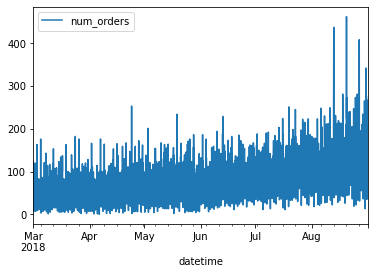

In [7]:
data = df.resample('1H').sum()
data.plot()

In [8]:
def count_missing(df): # функция для подсчета пропусков в столбцах
    nan = df.isnull().sum().sort_values(ascending=False) 
    missing_val = nan[nan > 0]
    return missing_val
print(count_missing(data))

Series([], dtype: int64)


## 2. Анализ данных

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

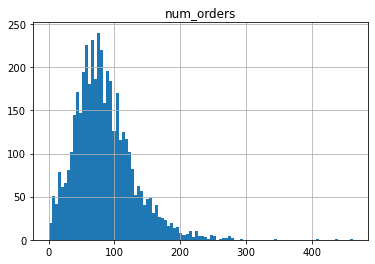

In [9]:
print(data.describe())

data.hist(bins=100)

In [10]:
# поиск трендов

decomposed = seasonal_decompose(data) 

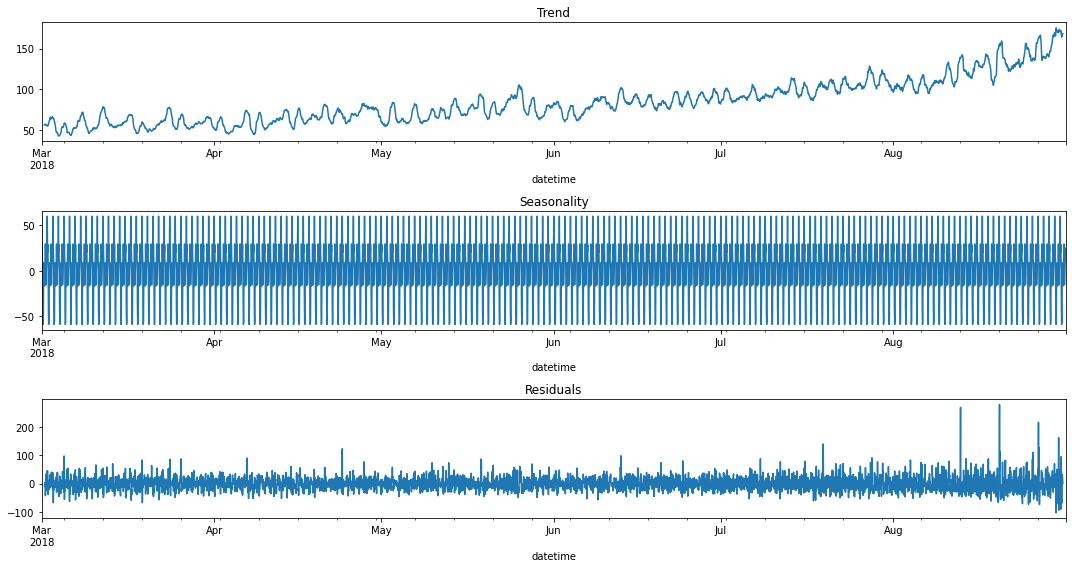

In [11]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (get current axis = получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Если верить графикам, количество вызовов такси со временем растет. Учитывая, что датасет сгруппирован по часам, скорее всего интересное найдется при анализе суточных или недельных колебаний.

<AxesSubplot:xlabel='datetime'>

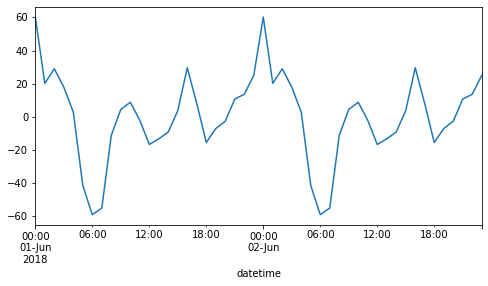

In [12]:
decomposed.seasonal['2018-06-01':'2018-06-02'].plot(figsize=(8, 4)) # суточные колебания за 1 июня

Пик около полуночи, спад около 6 утра

<AxesSubplot:xlabel='datetime'>

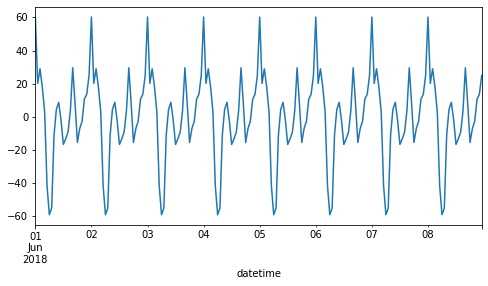

In [13]:
decomposed.seasonal['2018-06-01':'2018-06-08'].plot(figsize=(8, 4)) # колебания за 1 неделю

## 3. Обучение моделей

### Создание признаков

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['month'] = data.index.month  # календарные признаки
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    new_data['hour'] = data.index.hour
    
    for i in range(max_lag):   # "отстающие" значения
        new_data['lag_{}'.format(i+1)] = data['num_orders'].shift(i+1)
        
    new_data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() # скользящее среднее
    return new_data
    

new_data = make_features(data, 6, 8)
display(new_data.head())

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


In [15]:
new_data = new_data.dropna() # избавимся от пропусков
new_data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,52.750
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,41.500
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,39.500
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,38.625
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,42.375


### Разделение данных на обучающие и тренировочные

In [16]:
train, test = train_test_split(new_data, shuffle=False, test_size=0.1) #обучающая и тестовая выборки

print(train.index.min(), train.index.max()) # нужно убедиться, что они идут по временному ряду друг за другом
print(test.index.min(), test.index.max())

2018-03-01 08:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


In [17]:
# выделение целевого признака
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

### Обучение моделей

In [18]:
#функция метрики для кросс-валидации
def rmse(true, pred):
    return mean_squared_error(true, pred) ** 0.5
rmse_score = make_scorer(rmse)

In [19]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
def cross_validation(est):
    all_scores = cross_val_score(scoring=rmse_score,estimator=est, X=features_train, y=target_train, cv=tscv)
    return all_scores.mean()

In [20]:
# линейная регрессия
model_1 = LinearRegression() # инициализация модели
model_1.fit(features_train, target_train) # обучение модели на тренировочной выборке
predictions = model_1.predict(features_train) # предсказания модели на тренировочной выборке
mse = mean_squared_error(target_train, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 30.426558356128783


In [21]:
# линейная регрессия
print('средняя точность на валидационных выборках:',cross_validation(model_1))

средняя точность на валидационных выборках: 31.51456521840297


In [22]:
#DecisionTreeRegressor
model_2 = DecisionTreeRegressor()
model_2.fit(features_train, target_train) # обучение модели на тренировочной выборке
predictions = model_2.predict(features_train) # предсказания модели на тренировочной выборке
mse = mean_squared_error(target_train, predictions)
print("RMSE =", mse ** 0.5)
print('средняя точность на валидационных выборках:',cross_validation(model_2))

RMSE = 0.0
средняя точность на валидационных выборках: 31.658369760988524


In [23]:
%time
#RandomForestRegressor
#подбор гиперпараметров
#max_depth
model_3_1 = None
best_depth = 0
best_result = 40
for depth in range(3, 8, 1):
    model = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=12345)
    score = cross_validation(model)
    if score < best_result:
        model_3_1 = model
        best_result = score
        best_depth_1 = depth
        
print('best_result = ', best_result, 'depth = ', best_depth_1)

Wall time: 0 ns
best_result =  26.83463048606572 depth =  7


In [24]:
%time
#RandomForestRegressor
#подбор гиперпараметров
#n_estimators
for est in range(15, 150, 30):
    model = RandomForestRegressor(n_estimators=est, max_depth=best_depth_1, random_state=12345)
    score = cross_validation(model)
    if score < best_result:
        model_3_2 = model
        best_result = score
        best_est_1 = est
print('best_result = ', best_result, 'est = ', best_est_1)

Wall time: 0 ns
best_result =  26.754663355659705 est =  105


In [25]:
%time
#RandomForestRegressor
#подбор гиперпараметров
#n_estimators
best_est = 0
for est in range(80, 125, 5):
    model = RandomForestRegressor(n_estimators=est, max_depth=best_depth_1, random_state=12345)
    score = cross_validation(model)
    if score < best_result:
        model_3_2 = model
        best_result = score
        best_est_1 = est
print('best_result = ', best_result, 'est = ', best_est_1)

Wall time: 0 ns
best_result =  26.754663355659705 est =  105


In [26]:
%time
#RandomForestRegressor
#подбор гиперпараметров
#n_estimators
for est in range(100, 110, 1):
    model = RandomForestRegressor(n_estimators=est, max_depth=best_depth_1, random_state=12345)
    score = cross_validation(model)
    if score < best_result:
        model_3_2 = model
        best_result = score
        best_est_1 = est
print('best_result = ', best_result, 'est = ', best_est_1)

Wall time: 0 ns
best_result =  26.750140364523315 est =  108


In [27]:
#RandomForestRegressor - обучение
model_3_2.fit(features_train, target_train)

RandomForestRegressor(max_depth=7, n_estimators=108, random_state=12345)

In [28]:
#cat boost
model_cat = CatBoostRegressor(loss_function='RMSE', iterations=200)
model_cat.fit(features_train, target_train, verbose=30)
predictions = model_cat.predict(features_train)
mse = mean_squared_error(target_train, predictions)
print("RMSE =", mse ** 0.5)
cross_validation(model_cat)

Learning rate set to 0.188365
0:	learn: 35.7087667	total: 161ms	remaining: 32s
30:	learn: 22.2411001	total: 263ms	remaining: 1.43s
60:	learn: 19.9566492	total: 350ms	remaining: 797ms
90:	learn: 18.3365115	total: 439ms	remaining: 526ms
120:	learn: 17.0001649	total: 542ms	remaining: 354ms
150:	learn: 15.9224589	total: 632ms	remaining: 205ms
180:	learn: 15.1079376	total: 726ms	remaining: 76.2ms
199:	learn: 14.6486200	total: 796ms	remaining: 0us
RMSE = 14.648619953549844
Learning rate set to 0.141951
0:	learn: 27.6367688	total: 7.18ms	remaining: 1.43s
1:	learn: 25.9703103	total: 9.24ms	remaining: 915ms
2:	learn: 24.5062353	total: 11.2ms	remaining: 736ms
3:	learn: 23.2917056	total: 13.1ms	remaining: 641ms
4:	learn: 22.2848396	total: 15ms	remaining: 585ms
5:	learn: 21.4744936	total: 16.9ms	remaining: 545ms
6:	learn: 20.7851995	total: 18.7ms	remaining: 516ms
7:	learn: 20.1706436	total: 21ms	remaining: 505ms
8:	learn: 19.5044485	total: 23ms	remaining: 487ms
9:	learn: 19.1498699	total: 24.7ms	r

1:	learn: 26.9032757	total: 24.7ms	remaining: 2.44s
2:	learn: 25.6703435	total: 29ms	remaining: 1.91s
3:	learn: 24.5771182	total: 32.9ms	remaining: 1.61s
4:	learn: 23.4801448	total: 38.8ms	remaining: 1.51s
5:	learn: 22.7604375	total: 43.2ms	remaining: 1.4s
6:	learn: 22.2212589	total: 47.2ms	remaining: 1.3s
7:	learn: 21.6538503	total: 52.9ms	remaining: 1.27s
8:	learn: 21.3355885	total: 55.8ms	remaining: 1.18s
9:	learn: 20.9209749	total: 59.8ms	remaining: 1.14s
10:	learn: 20.6289916	total: 62.6ms	remaining: 1.08s
11:	learn: 20.3231440	total: 66.5ms	remaining: 1.04s
12:	learn: 20.1110265	total: 68.8ms	remaining: 990ms
13:	learn: 19.8174627	total: 72ms	remaining: 956ms
14:	learn: 19.5668666	total: 74.3ms	remaining: 916ms
15:	learn: 19.3226487	total: 76.7ms	remaining: 882ms
16:	learn: 19.0960670	total: 79.5ms	remaining: 856ms
17:	learn: 18.9660902	total: 82.4ms	remaining: 833ms
18:	learn: 18.7829085	total: 85.5ms	remaining: 814ms
19:	learn: 18.6701801	total: 87.7ms	remaining: 789ms
20:	lear

192:	learn: 8.9962201	total: 541ms	remaining: 19.6ms
193:	learn: 8.9512753	total: 544ms	remaining: 16.8ms
194:	learn: 8.9255103	total: 549ms	remaining: 14.1ms
195:	learn: 8.9040357	total: 552ms	remaining: 11.3ms
196:	learn: 8.8872774	total: 558ms	remaining: 8.49ms
197:	learn: 8.8593880	total: 563ms	remaining: 5.68ms
198:	learn: 8.7971254	total: 565ms	remaining: 2.84ms
199:	learn: 8.7855103	total: 567ms	remaining: 0us
Learning rate set to 0.168832
0:	learn: 29.6111089	total: 12.1ms	remaining: 2.4s
1:	learn: 27.8881420	total: 14.7ms	remaining: 1.46s
2:	learn: 26.5011467	total: 18.2ms	remaining: 1.19s
3:	learn: 25.5616955	total: 20.7ms	remaining: 1.02s
4:	learn: 24.6771906	total: 24.7ms	remaining: 965ms
5:	learn: 23.9081040	total: 28ms	remaining: 906ms
6:	learn: 23.0952195	total: 31.5ms	remaining: 870ms
7:	learn: 22.4772268	total: 34ms	remaining: 816ms
8:	learn: 21.9499994	total: 37.4ms	remaining: 794ms
9:	learn: 21.6323980	total: 40.6ms	remaining: 771ms
10:	learn: 21.4404336	total: 44.1m

155:	learn: 11.9134133	total: 461ms	remaining: 130ms
156:	learn: 11.8987098	total: 465ms	remaining: 127ms
157:	learn: 11.8720781	total: 470ms	remaining: 125ms
158:	learn: 11.8374421	total: 474ms	remaining: 122ms
159:	learn: 11.7769570	total: 476ms	remaining: 119ms
160:	learn: 11.7365869	total: 479ms	remaining: 116ms
161:	learn: 11.7139424	total: 481ms	remaining: 113ms
162:	learn: 11.6706731	total: 483ms	remaining: 110ms
163:	learn: 11.6185650	total: 486ms	remaining: 107ms
164:	learn: 11.5952550	total: 489ms	remaining: 104ms
165:	learn: 11.5479916	total: 491ms	remaining: 101ms
166:	learn: 11.5335864	total: 493ms	remaining: 97.5ms
167:	learn: 11.5325354	total: 496ms	remaining: 94.4ms
168:	learn: 11.5306808	total: 498ms	remaining: 91.4ms
169:	learn: 11.5142810	total: 501ms	remaining: 88.4ms
170:	learn: 11.4963454	total: 503ms	remaining: 85.4ms
171:	learn: 11.4374103	total: 506ms	remaining: 82.3ms
172:	learn: 11.3992557	total: 508ms	remaining: 79.3ms
173:	learn: 11.3459011	total: 510ms	rem

119:	learn: 14.5171655	total: 383ms	remaining: 255ms
120:	learn: 14.5155297	total: 387ms	remaining: 253ms
121:	learn: 14.5137313	total: 392ms	remaining: 250ms
122:	learn: 14.4505055	total: 395ms	remaining: 247ms
123:	learn: 14.3997046	total: 398ms	remaining: 244ms
124:	learn: 14.3793607	total: 401ms	remaining: 240ms
125:	learn: 14.3526815	total: 403ms	remaining: 237ms
126:	learn: 14.3157866	total: 406ms	remaining: 233ms
127:	learn: 14.2666044	total: 409ms	remaining: 230ms
128:	learn: 14.2359214	total: 412ms	remaining: 227ms
129:	learn: 14.1943687	total: 415ms	remaining: 223ms
130:	learn: 14.1701642	total: 417ms	remaining: 220ms
131:	learn: 14.1371077	total: 420ms	remaining: 216ms
132:	learn: 14.0901358	total: 423ms	remaining: 213ms
133:	learn: 14.0628856	total: 426ms	remaining: 210ms
134:	learn: 14.0035369	total: 429ms	remaining: 206ms
135:	learn: 13.9356981	total: 431ms	remaining: 203ms
136:	learn: 13.8882017	total: 434ms	remaining: 200ms
137:	learn: 13.8364068	total: 437ms	remaining:

122:	learn: 15.3644470	total: 394ms	remaining: 247ms
123:	learn: 15.3172254	total: 398ms	remaining: 244ms
124:	learn: 15.2763714	total: 402ms	remaining: 241ms
125:	learn: 15.2613134	total: 406ms	remaining: 238ms
126:	learn: 15.2015865	total: 411ms	remaining: 236ms
127:	learn: 15.1656560	total: 415ms	remaining: 234ms
128:	learn: 15.1450289	total: 420ms	remaining: 231ms
129:	learn: 15.1110036	total: 424ms	remaining: 228ms
130:	learn: 15.0800317	total: 427ms	remaining: 225ms
131:	learn: 15.0606214	total: 431ms	remaining: 222ms
132:	learn: 15.0261228	total: 434ms	remaining: 218ms
133:	learn: 14.9959373	total: 438ms	remaining: 216ms
134:	learn: 14.9929962	total: 440ms	remaining: 212ms
135:	learn: 14.9243460	total: 443ms	remaining: 209ms
136:	learn: 14.8853896	total: 447ms	remaining: 205ms
137:	learn: 14.8345483	total: 450ms	remaining: 202ms
138:	learn: 14.8287581	total: 452ms	remaining: 199ms
139:	learn: 14.8222147	total: 455ms	remaining: 195ms
140:	learn: 14.7706651	total: 458ms	remaining:

25.284797817274683

RMSE(cat boost, CV) = 25.28

In [30]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'verbose': 100,
    "max_depth": 8,
    "num_leaves": 64,
    "min_data_in_leaf": 13,
    "max_bin": 512,
    "num_iterations": 200
    
}
gbm = LGBMRegressor(**hyper_params)
gbm.fit(features_train, target_train)
predictions = gbm.predict(features_train, num_iteration=gbm.best_iteration_)
mse = mean_squared_error(target_train, predictions)
print("RMSE =", mse ** 0.5)

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.016912
[LightGBM] [Debug] init for col-wise cost 0.000191 seconds, init for row-wise cost 0.000577 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 3967, number of used features: 11
[LightGBM] [Info] Start training from score 78.348122
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth

C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 52 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Deb

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 56 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

RMSE = 8.978182985556966


In [31]:
cross_validation(gbm)

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.018580
[LightGBM] [Debug] init for col-wise cost 0.000678 seconds, init for row-wise cost 0.000474 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 662, number of used features: 10
[LightGBM] [Info] Start training from score 57.090634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Tr

C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 57 and depth = 8
[LightGBM] [Warning]

C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[LightGBM] [Debug] Trained a tree with leaves = 52 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 61 and depth = 8
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 55 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 63 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 54 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 60 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 47 and depth = 8
[LightGBM] [Warning]

C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[LightGBM] [Debug] Trained a tree with leaves = 51 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 59 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] 

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.017159
[LightGBM] [Debug] init for col-wise cost 0.000008 seconds, init for row-wise cost 0.000606 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1619
[LightGBM] [Info] Number of data points in the train set: 3306, number of used features: 11
[LightGBM] [Info] Start training from score 72.486993
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8


C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Traine

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 8
[LightGBM] [Warning]

25.740915937309687

Лучшее RMSE на тренировочной выборке после кросс-валидации оказалось у LGBMRegressor - 25.74 (дерево решений не cчитается, оно "выучило" обучающую выборку)

## 4. Тестирование

In [32]:
# линейная регрессия
predictions = model_1.predict(features_test) # предсказания модели на тестовой выборке
mse = mean_squared_error(target_test, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 52.677278167944


In [33]:
#DecisionTreeRegressor
predictions = model_2.predict(features_test) # предсказания модели на тестовой выборке
mse = mean_squared_error(target_test, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 54.6681184476215


In [34]:
#RandomForestRegressor
predictions = model_3_2.predict(features_test) # предсказания модели на тестовой выборке
mse = mean_squared_error(target_test, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 50.41232469249034


In [35]:
#cat boost
cat_predictions = model_cat.predict(features_test)
mse = mean_squared_error(target_test, cat_predictions)
print("RMSE =", mse ** 0.5)

RMSE = 44.40830481468448


In [36]:
gbm_predictions = gbm.predict(features_test, num_iteration=gbm.best_iteration_)
mse = mean_squared_error(target_test, gbm_predictions)
print("RMSE =", mse ** 0.5)

RMSE = 40.936597978012195


In [37]:
from optuna.integration import LightGBMPruningCallback
def objective(trial, features_train, target_train):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 3500, 3800 , step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 30, 170, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100, step=10),
        "max_bin": trial.suggest_int("max_bin", 200, 250),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 7, 10, step=0.5),
        "num_iterations": 200
    }
    
    cv = tscv #TimeSeriesSplit

    gbm_opt = LGBMRegressor(**params)
    scores = cross_validate(gbm_opt, features_train, target_train, cv=cv, scoring=rmse_score, n_jobs=-1)
    
    rmse = scores["test_score"].mean()

    return rmse

In [38]:
# Create study that minimizes
study = optuna.create_study(direction="minimize")

# Wrap the objective inside a lambda with the relevant arguments
# Pass additional arguments inside another function
func = lambda trial: objective(trial, features_train, target_train)

# Start optimizing with 100 trials
study.optimize(func, n_trials=100)

print(f"Optimized RMSE: {study.best_value:.5f}")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2022-08-10 15:20:13,099] A new study created in memory with name: no-name-e7100cc4-eec6-42fe-b10e-149c550d4a52
[I 2022-08-10 15:20:19,717] Trial 0 finished with value: 25.887586020764342 and parameters: {'n_estimators': 3500, 'learning_rate': 0.03673568464146169, 'num_leaves': 50, 'max_depth': 6, 'min_data_in_leaf': 80, 'max_bin': 215, 'min_gain_to_split': 10.0}. Best is trial 0 with value: 25.887586020764342.
[I 2022-08-10 15:20:20,094] Trial 1 finished with value: 25.770636374517217 and parameters: {'n_estimators': 3550, 'learning_rate': 0.1590045970004251, 'num_leaves': 170, 'max_depth': 6, 'min_data_in_leaf': 40, 'max_bin': 223, 'min_gain_to_split': 9.5}. Best is trial 1 with value: 25.770636374517217.
[I 2022-08-10 15:20:20,527] Trial 2 finished with value: 26.155821908567646 and parameters: {'n_estimators': 3700, 'learning_rate': 0.17011770780434454, 'num_leaves': 100, 'max_depth': 8, 'min_data_in_leaf': 60, 'max_bin': 219, 'min_gain_to_split': 8.5}. Best is trial 1 with value

[I 2022-08-10 15:20:30,144] Trial 26 finished with value: 26.521889606171374 and parameters: {'n_estimators': 3750, 'learning_rate': 0.024128551212696456, 'num_leaves': 130, 'max_depth': 4, 'min_data_in_leaf': 60, 'max_bin': 207, 'min_gain_to_split': 7.5}. Best is trial 12 with value: 25.247710013633526.
[I 2022-08-10 15:20:30,447] Trial 27 finished with value: 25.378958513528115 and parameters: {'n_estimators': 3700, 'learning_rate': 0.06858514230843378, 'num_leaves': 150, 'max_depth': 3, 'min_data_in_leaf': 20, 'max_bin': 213, 'min_gain_to_split': 7.0}. Best is trial 12 with value: 25.247710013633526.
[I 2022-08-10 15:20:30,834] Trial 28 finished with value: 25.45286477430137 and parameters: {'n_estimators': 3500, 'learning_rate': 0.09874313443383834, 'num_leaves': 130, 'max_depth': 5, 'min_data_in_leaf': 50, 'max_bin': 218, 'min_gain_to_split': 7.5}. Best is trial 12 with value: 25.247710013633526.
[I 2022-08-10 15:20:31,495] Trial 29 finished with value: 25.65368382341517 and param

[I 2022-08-10 15:20:47,826] Trial 52 finished with value: 25.16571447714114 and parameters: {'n_estimators': 3550, 'learning_rate': 0.021630670324313046, 'num_leaves': 170, 'max_depth': 8, 'min_data_in_leaf': 40, 'max_bin': 238, 'min_gain_to_split': 9.5}. Best is trial 33 with value: 25.005316200804916.
[I 2022-08-10 15:20:48,385] Trial 53 finished with value: 25.085863978236972 and parameters: {'n_estimators': 3500, 'learning_rate': 0.04384687862948628, 'num_leaves': 160, 'max_depth': 7, 'min_data_in_leaf': 30, 'max_bin': 236, 'min_gain_to_split': 9.5}. Best is trial 33 with value: 25.005316200804916.
[I 2022-08-10 15:20:48,878] Trial 54 finished with value: 26.303044335701497 and parameters: {'n_estimators': 3600, 'learning_rate': 0.015930455925028748, 'num_leaves': 150, 'max_depth': 8, 'min_data_in_leaf': 60, 'max_bin': 228, 'min_gain_to_split': 9.0}. Best is trial 33 with value: 25.005316200804916.
[I 2022-08-10 15:20:49,258] Trial 55 finished with value: 26.370783499268374 and par

[I 2022-08-10 15:21:02,443] Trial 78 finished with value: 25.48968175626677 and parameters: {'n_estimators': 3550, 'learning_rate': 0.08356638743211911, 'num_leaves': 170, 'max_depth': 8, 'min_data_in_leaf': 30, 'max_bin': 226, 'min_gain_to_split': 8.5}. Best is trial 33 with value: 25.005316200804916.
[I 2022-08-10 15:21:02,959] Trial 79 finished with value: 25.463984507745188 and parameters: {'n_estimators': 3600, 'learning_rate': 0.021820939381178805, 'num_leaves': 160, 'max_depth': 7, 'min_data_in_leaf': 50, 'max_bin': 242, 'min_gain_to_split': 9.5}. Best is trial 33 with value: 25.005316200804916.
[I 2022-08-10 15:21:03,574] Trial 80 finished with value: 25.06837082878915 and parameters: {'n_estimators': 3550, 'learning_rate': 0.030627087752583534, 'num_leaves': 130, 'max_depth': 9, 'min_data_in_leaf': 40, 'max_bin': 235, 'min_gain_to_split': 9.0}. Best is trial 33 with value: 25.005316200804916.
[I 2022-08-10 15:21:04,149] Trial 81 finished with value: 25.055612076166295 and para

Optimized RMSE: 25.00532
		n_estimators: 3550
		learning_rate: 0.03523767656713235
		num_leaves: 170
		max_depth: 8
		min_data_in_leaf: 40
		max_bin: 238
		min_gain_to_split: 7.5


In [39]:
# а теперь проверим на тестовой выборке
best_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'verbose': 100,
    "n_estimators": 3500,
    "learning_rate": 0.024174523317104714,
    "num_leaves": 160,
    "max_depth": 9,
    "min_data_in_leaf": 30,
    "max_bin": 204,
    "min_gain_to_split": 7
    }

gbm_opt = LGBMRegressor(**best_params)
gbm_opt.fit(features_train, target_train)
gbm_opt_predictions = gbm_opt.predict(features_test, num_iteration=gbm.best_iteration_)
mse = mean_squared_error(target_test, gbm_opt_predictions)
print("RMSE =", mse ** 0.5)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=7, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=7, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.016912
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.000782 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 3967, number of used features: 11
[LightGBM] [Info] Start training from score 78.3

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 73 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 84 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 78 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 71 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 72 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 74 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 74 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 49 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 46 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 46 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 47 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 6 and depth = 5
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 1 and depth = 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 1 and depth = 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 1 and depth = 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 1 and depth = 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furt

RMSE = 43.63808185582019


Применен алгоритм для подбора гиперпараметров Optuna для улучшения работы LGBM, однако ручной подбор параметров оказался эффективнее.

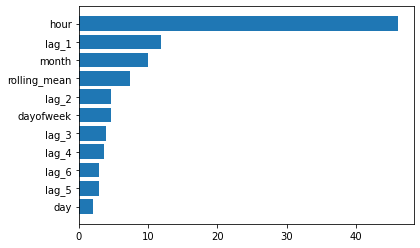

In [40]:
importances = model_cat.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(features_train.columns)[indices])

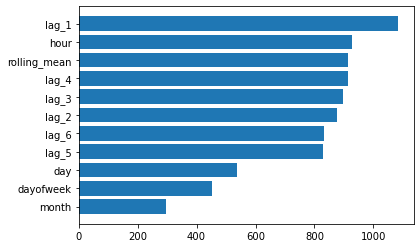

In [41]:
importances = gbm.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(features_train.columns)[indices])

In [42]:
target_test_plot = target_test.reset_index(drop=True)

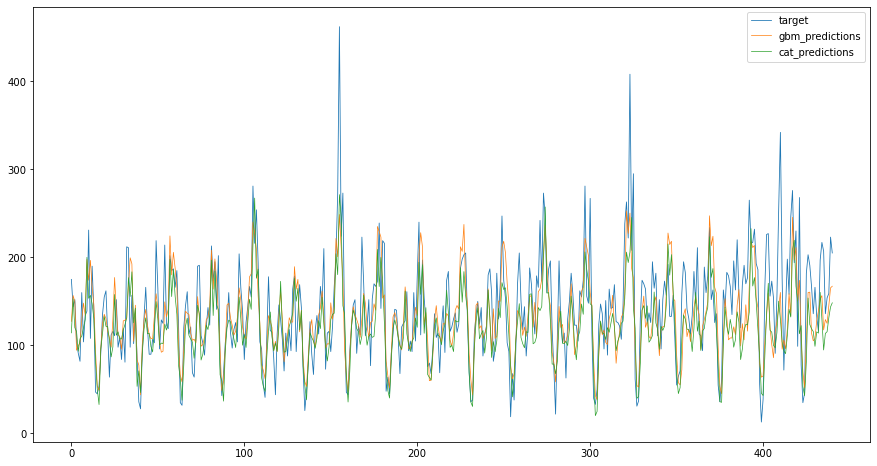

In [43]:
# график соответствия тесовой выборки предсказаниям
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(target_test_plot,linewidth  = 0.8, label='target')
ax.plot(gbm_predictions, linewidth  = 0.7, label='gbm_predictions')
ax.plot(cat_predictions, linewidth  = 0.7, label='cat_predictions')
ax.legend()
plt.show()

Лучшей моделью для прогнозирования количества заказов в час оказался lightgbm regressor (RMSE = 40.9), также в заданный порог (RMSE < 48) попадает CatBoostRegressor (RMSE = 44.4). Согласно анализу Feature importances подход этих моделей несколько различался. Обе модели единогласно приняли за самый важный признак время суток - час, это было понятно ещё на этапе анализа данных, были выявлены четкие суточные колебания количества вызовов. Далее LGBM опирался на значение скользящего среднего, которое усредняло окружающие 8 значений, а CatBoost c гораздо меньшей важностью учитывал значение Lag_1. 